# Step 1. Load and prepare the data

In [10]:
import numpy as np
import laspy as lp
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [11]:
#Load the file

point_cloud=lp.read("./data/Wellington.las")

#store coordinates in "points", and colors in "colors" variable
points = np.vstack((point_cloud.x, point_cloud.y, point_cloud.z)).transpose()
colors = np.vstack((point_cloud.red, point_cloud.green, point_cloud.blue)).transpose()

# Step 2. Choose a sampling strategy

## 1. Point cloud decimation

In [3]:
#The decimation strategy, by setting a decimation factor
factor=160
decimated_points = points[::factor]
decimated_colors = colors[::factor]
len(decimated_points)

87457

## 2. Point cloud voxel grid

In [6]:
# Initialize the number of voxels to create to fill the space including every point
voxel_size=6
nb_vox=np.ceil((np.max(points, axis=0) - np.min(points, axis=0))/voxel_size)
#nb_vox.astype(int) #this gives you the number of voxels per axis

print(nb_vox)

In [7]:
# Compute the non empty voxels and keep a trace of indexes that we can relate to points in order to store points later on.
# Also Sum and count the points in each voxel.
non_empty_voxel_keys, inverse, nb_pts_per_voxel= np.unique(((points - np.min(points, axis=0)) // voxel_size).astype(int), axis=0, return_inverse=True, return_counts=True)
idx_pts_vox_sorted=np.argsort(inverse)
#len(non_empty_voxel_keys) # if you need to display how many no-empty voxels you have

print(non_empty_voxel_keys)



[[  0   0  49]
 [  0   0  50]
 [  0   1  49]
 ...
 [253 152  12]
 [253 153  10]
 [253 153  11]]


In [5]:
#Here, we loop over non_empty_voxel_keys numpy array to
#       > Store voxel indices as keys in a dictionnary
#       > Store the related points as the value of each key
#       > Compute each voxel barycenter and add it to a list
#       > Compute each voxel closest point to the barycenter and add it to a list

voxel_grid={}
grid_barycenter,grid_candidate_center=[],[]
last_seen=0

for idx,vox in enumerate(non_empty_voxel_keys):
  voxel_grid[tuple(vox)]=points[idx_pts_vox_sorted[last_seen:last_seen+nb_pts_per_voxel[idx]]]
  grid_barycenter.append(np.mean(voxel_grid[tuple(vox)],axis=0))
  grid_candidate_center.append(voxel_grid[tuple(vox)][np.linalg.norm(voxel_grid[tuple(vox)]-np.mean(voxel_grid[tuple(vox)],axis=0),axis=1).argmin()])
  last_seen+=nb_pts_per_voxel[idx]

NameError: name 'non_empty_voxel_keys' is not defined

# Step 3. Visualize and export the results

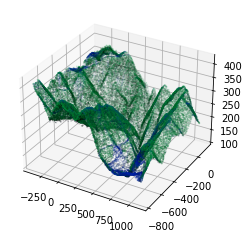

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

ax = plt.axes(projection='3d')
ax.scatter(decimated_points[:,0], decimated_points[:,1], decimated_points[:,2], c = decimated_colors/65535, s=0.01)
plt.show()

In [ ]:
%timeit np.savetxt(output_path+dataname+"_voxel-best_point_%s.xyz" % (voxel_size), grid_candidate_center, delimiter=";", fmt="%s")

# Step 4. Automate with functions

In [ ]:
#Define a function that takes as input an array of points, and a voxel size expressed in meters. It returns the sampled point cloud
def grid_subsampling(points, voxel_size):

  nb_vox=np.ceil((np.max(points, axis=0) - np.min(points, axis=0))/voxel_size)
  non_empty_voxel_keys, inverse, nb_pts_per_voxel= np.unique(((points - np.min(points, axis=0)) // voxel_size).astype(int), axis=0, return_inverse=True, return_counts=True)
  idx_pts_vox_sorted=np.argsort(inverse)
  voxel_grid={}
  grid_barycenter,grid_candidate_center=[],[]
  last_seen=0

  for idx,vox in enumerate(non_empty_voxel_keys):
    voxel_grid[tuple(vox)]=points[idx_pts_vox_sorted[last_seen:last_seen+nb_pts_per_voxel[idx]]]
    grid_barycenter.append(np.mean(voxel_grid[tuple(vox)],axis=0))
    grid_candidate_center.append(voxel_grid[tuple(vox)][np.linalg.norm(voxel_grid[tuple(vox)]-np.mean(voxel_grid[tuple(vox)],axis=0),axis=1).argmin()])
    last_seen+=nb_pts_per_voxel[idx]

  return grid_candidate_center

In [ ]:
#Execute the function, and store the results in the grid_sampled_point_cloud variable
grid_sampled_point_cloud variable = grid_subsampling(point_cloud, 6)

#Save the variable to an ASCII file to open in a 3D Software
%timeit np.savetxt("_sampled.xyz", grid_sampled_point_cloud variable, delimiter=";", fmt="%s")

# Subsampling with Open3D

In [13]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors)

In [14]:
downpcd = pcd.voxel_down_sample(voxel_size=6)

In [15]:
# visualization
o3d.visualization.draw_geometries([downpcd])

In [17]:
print(downpcd)

PointCloud with 93023 points.
